In [119]:
import pandas as pd
import numpy as np
import csv
from copy import deepcopy
from pandas import datetime
from copy import deepcopy
import gc
import random
import datetime
import csv
from copy import deepcopy
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm_notebook
from Downloader import Extractor
from Preprocessing import Preprocessor, set_onelevel, set_multilevel
from Filters import XGBFilter
from Filters import quantile_huber_loss, quantile_huber_obj 
import pickle
import xgboost as xgb

In [120]:
# getting file tree in directory "data_csv", which contains raw unfiltered data
mypath = './data_csv/Raw'
dateparse = pd.to_datetime
station_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) if int(f.split('_', 1)[0])]
station_files.sort()

# reading loaded csv files from data_csv directory, output is a list (length=number of stations) of raw df 
raw_lmeteo_list = [pd.read_csv(mypath + '/' + station, index_col=0, 
                    dtype={'station_id': int,'date_time': str}, 
                    date_parser = dateparse, parse_dates = ['date_time']) 
                   for station in tqdm_notebook(station_files[:6])]

#fix problems with indexing, later this will be solved in loading part
for elem in raw_lmeteo_list:
    elem.reset_index(drop=True, inplace=True)

raw_data = pd.concat(raw_lmeteo_list)
raw_data['id'] = random.sample(range(len(raw_data)), len(raw_data))
raw_data['valid'] = True
raw_data = raw_data.reset_index(drop=True)

del raw_lmeteo_list
gc.collect()

raw_data

,station_data_id,sensor_id,data,station_id,sensor_type_id,active_state,name,rule_id,rule_ordr,direction,lane_traffic,date_time,poll_interval,fake_data,type,unit_of_measure,description,id,valid
0,7137045.0,6032.0,7357.0,113,16.0,A,NaN,152.0,36.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,pressure,NaN,pressure (sw),1023122,True
1,7137045.0,6021.0,140.0,113,2.0,A,NaN,154.0,14.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,t_road,NaN,t_road (sw),269809,True
2,7137045.0,6020.0,136.0,113,1.0,A,NaN,4.0,12.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,t_air,NaN,t_air (sw),520724,True
3,7137045.0,6022.0,140.0,113,3.0,A,NaN,155.0,16.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,t_underroad,NaN,t_underroad (sw),1511689,True
4,7137045.0,6023.0,831.0,113,4.0,A,NaN,6.0,18.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,dampness,NaN,dampness (sw),1612783,True
5,7137243.0,6032.0,7398.0,113,16.0,A,NaN,152.0,36.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,pressure,NaN,pressure (sw),1588767,True
6,7137243.0,6021.0,194.0,113,2.0,A,NaN,154.0,14.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,t_road,NaN,t_road (sw),637601,True
7,7137243.0,6020.0,156.0,113,1.0,A,NaN,4.0,12.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,t_air,NaN,t_air (sw),1378936,True
8,7137243.0,6022.0,187.0,113,3.0,A,NaN,155.0,16.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,t_underroad,NaN,t_underroad (sw),1719039,True
9,7137243.0,6023.0,664.0,113,4.0,A,NaN,6.0,18.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,dampness,NaN,dampness (sw),1051329,True


In [107]:
preprocessor = Preprocessor()
meteo_splitted = preprocessor.PivotTable(raw_data)
patterns_list = preprocessor.CreatePatternList(meteo_splitted)
patterns_interpolated = preprocessor.InterpolatePatterns(patterns_list)

In [108]:
import ephem

def grad(lst):
    return lst[0] + lst[1] / 60 + lst[2] / 3600

def solar_angles(lat, lon, date_time):
    lat = grad([int(elem) for elem in lat.split(' ')])
    lon = grad([int(elem) for elem in lon.split(' ')])
    gatech = ephem.Observer()
    sun = ephem.Sun()
    gatech.lat, gatech.lon, gatech.date = str(lat), str(lon), date_time
    sun.compute(gatech)
    return sun.alt, sun.az

In [109]:
station_def = pd.read_csv("./data_csv/station_def.csv", encoding='cp1251',
                                  usecols=['station_id', 'latitude', 'longitude'], 
                                   na_values=r'\N',)
station_def = station_def.dropna()
station_def = station_def[station_def['longitude'].apply(len) > 7]
station_def = station_def[station_def['latitude'].apply(len) > 7]

cols = [('station_id', ''), ('data', 'latitude'), ('data', 'longitude')]
micolumns = pd.MultiIndex.from_tuples(cols)
station_def.columns = micolumns

z = pd.merge(meteo_splitted, station_def, 'left', on=[('station_id',)])
z = z.sort_index(axis=1)
z

/home/ndsviriden/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


data                                                         \
       dampness  latitude longitude pressure  t_air t_road t_underroad   
0         831.0  54 26 49  53 36 10   7357.0  136.0  140.0       140.0   
1         664.0  54 26 49  53 36 10   7398.0  156.0  194.0       187.0   
2         646.0  54 26 49  53 36 10   7398.0  157.0  200.0       187.0   
3         674.0  54 26 49  53 36 10   7398.0  152.0  194.0       181.0   
4         692.0  54 26 49  53 36 10   7406.0  147.0  190.0       177.0   
5         764.0  54 26 49  53 36 10   7406.0  135.0  141.0       145.0   
6        1000.0  54 26 49  53 36 10   7414.0   77.0   75.0        76.0   
7        1000.0  54 26 49  53 36 10   7414.0   62.0   56.0        58.0   
8        1000.0  54 26 49  53 36 10   7423.0   71.0   61.0        61.0   
9        1000.0  54 26 49  53 36 10   7414.0   60.0   56.0        58.0   
10       1000.0  54 26 49  53 36 10   7414.0   60.0   54.0        56.0   
11       1000.0  54 26 49  53 36 10   7423.0   59.0   53.0        53.0   
12       1000.0  54 26 49  53 36 10   7423.0   56.0   52.0        53.0   
13       1000.0  54 26 49  53 36 10   7431.0   42.0   42.0        44.0   
14       1000.0  54 26 49  53 36 10   7431.0   43.0   40.0        41.0   
15       1000.0  54 26 49  53 36 10   7423.0   39.0   36.0        38.0   
16       1000.0  54 26 49  53 36 10   7431.0   39.0   36.0        37.0   
17       1000.0  54 26 49  53 36 10   7431.0   37.0   36.0        36.0   
18       1000.0  54 26 49  53 36 10   7431.0   41.0   36.0        36.0   
19       1000.0  54 26 49  53 36 10   7439.0   51.0   46.0        45.0   
20       1000.0  54 26 49  53 36 10   7439.0   65.0   64.0        63.0   
21        932.0  54 26 49  53 36 10   7447.0  106.0  108.0       109.0   
22        889.0  54 26 49  53 36 10   7455.0  113.0  124.0       126.0   
23        866.0  54 26 49  53 36 10   7455.0  120.0  144.0       147.0   
24        838.0  54 26 49  53 36 10   7447.0  133.0  157.0       161.0   
25        749.0  54 26 49  53 36 10   7455.0  146.0  185.0       188.0   
26        672.0  54 26 49  53 36 10   7447.0  156.0  200.0       201.0   
27          NaN  54 26 49  53 36 10      NaN    NaN    NaN         NaN   
28        645.0  54 26 49  53 36 10   7447.0  164.0  193.0       191.0   
29        654.0  54 26 49  53 36 10   7455.0  164.0  208.0       199.0   
...         ...       ...       ...      ...    ...    ...         ...   
358502    826.0       NaN       NaN    746.0  169.0  217.0       223.0   
358503    801.0       NaN       NaN    746.0  177.0  233.0       228.0   
358504    772.0       NaN       NaN    746.0  186.0  249.0       236.0   
358505    748.0       NaN       NaN    746.0  194.0  271.0       246.0   
358506    718.0       NaN       NaN    746.0  202.0  295.0       259.0   
358507    683.0       NaN       NaN    746.0  217.0  317.0       274.0   
358508    639.0       NaN       NaN    746.0  226.0  325.0       287.0   
358509    530.0       NaN       NaN    746.0  231.0  347.0       301.0   
358510    515.0       NaN       NaN    746.0  239.0  380.0       317.0   
358511    504.0       NaN       NaN    746.0  241.0  393.0       331.0   
358512    440.0       NaN       NaN    746.0  257.0  424.0       358.0   
358513    411.0       NaN       NaN    746.0  253.0  418.0       369.0   
358514    419.0       NaN       NaN    746.0  258.0  434.0       366.0   
358515    399.0       NaN       NaN    746.0  258.0  436.0       385.0   
358516    398.0       NaN       NaN    746.0  264.0  451.0       389.0   
358517    410.0       NaN       NaN    745.0  263.0  428.0       392.0   
358518    401.0       NaN       NaN    745.0  268.0  440.0       396.0   
358519    401.0       NaN       NaN    745.0  269.0  425.0       388.0   
358520    401.0       NaN       NaN    745.0  265.0  400.0       388.0   
358521    432.0       NaN       NaN    745.0  262.0  372.0       376.0   
358522    428.0       NaN       NaN    745.0  265.0  370.0       367.0   
358523    423.0

In [86]:
pattern = patterns_interpolated[23]
from statsmodels.tsa.api import 

In [ ]:
meteo_splitted['altitude'] = meteo_splitted.apply(lambda row: 
                            solar_altitude(row['latitude'], row['longitude'], row['date_time']), axis=1)

meteo_splitted['azimuth'] = meteo_splitted.apply(lambda row: 
                            solar_azimuth(row['latitude'], row['longitude'], row['date_time']), axis=1)

In [63]:
%%time
preprocessor = Preprocessor()
meteo_splitted = preprocessor.PivotTable(raw_data)
del raw_data

patterns_list = preprocessor.CreatePatternList(meteo_splitted)
del pivoted_df

patterns_interpolated = preprocessor.InterpolatePatterns(patterns_list)
del patterns_list

patterns_lagged = preprocessor.CreateLaggedTable(patterns_interpolated)
del patterns_interpolated

final = pd.concat(patterns_lagged).reset_index(drop=True)



CPU times: user 1min 58s, sys: 1.12 s, total: 1min 59s
Wall time: 1min 58s


In [123]:
patterns_lagged = preprocessor.CreateLaggedTable(patterns_interpolated)

In [65]:
filt = XGBFilter()
z = filt.verify(final)

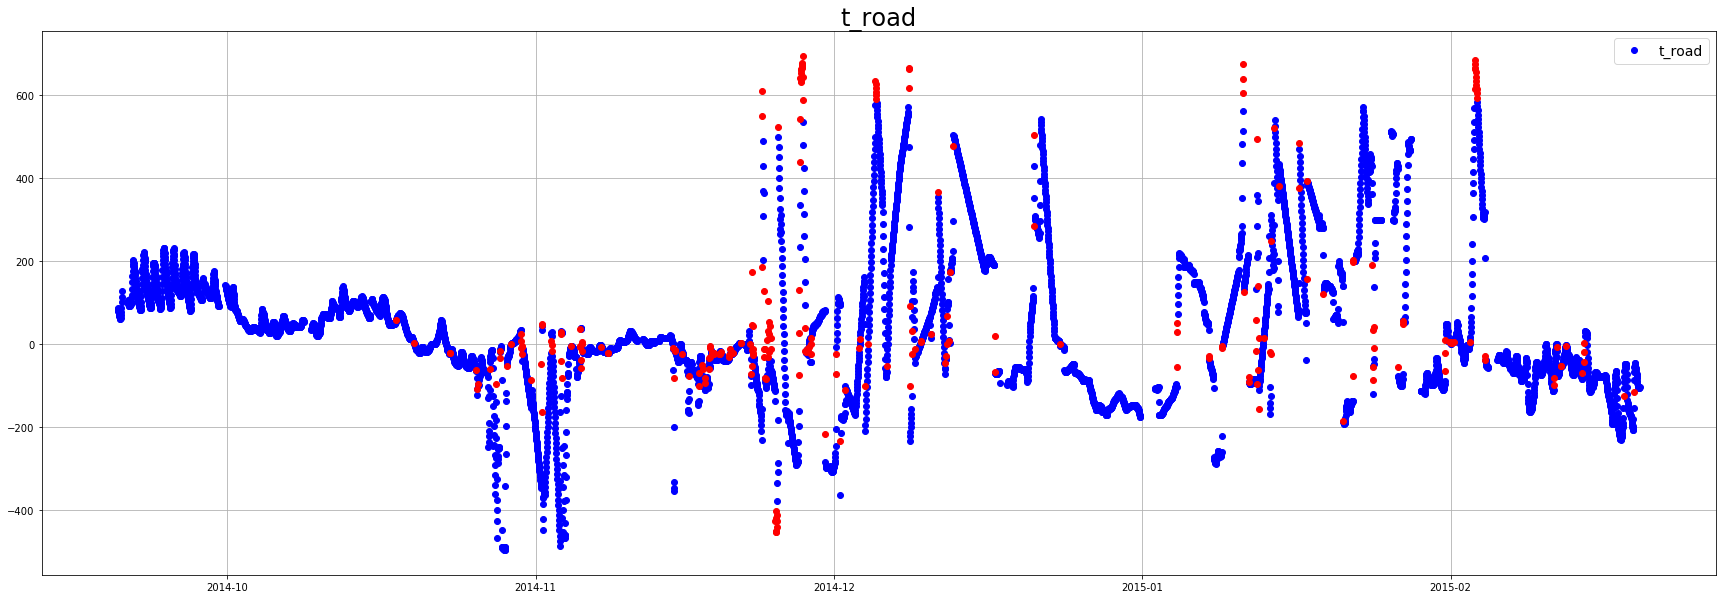

In [125]:
start='2014-09-20'
end='2015-02-20'
filt.plot_filter_result(station=113, start=start, end=end, sensors=['t_road'])

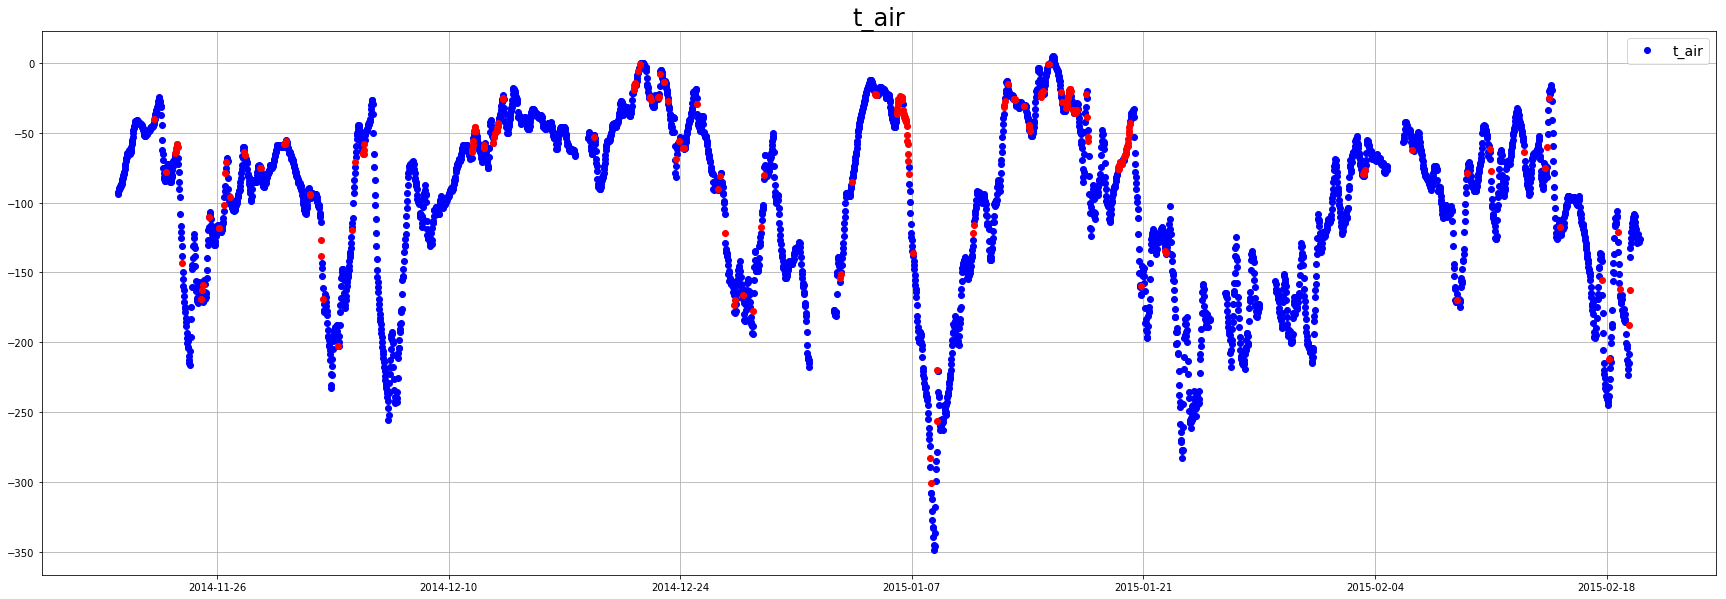

In [112]:
filt.plot_filter_result(station=113, start=start, end=end, sensors=['t_air'])

In [118]:
d = final[(final[('date_time', )] < pd.DateTend) & (final['date_time'] >= start)]
import matplotlib.pyplot as plt
plt.plot_date(d['date_time'], d[('data_dampness', 0)], 'b.', linestyle='none', marker='o', markersize=6)
plt.show()

TypeError: 

In [21]:
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from functools import partial

test_label = 't_road'

train = final[final[('date_time', 0)] < '2015-06']
val = final[final[('date_time', 0)] >= '2015-06']

dtrain = create_xgb_matrix(train, test_label)
dval = create_xgb_matrix(val, test_label)
dfinal = create_xgb_matrix(final, test_label)

params = {}

params["eval_metric"] = 'mae'
params["eta"] = 0.05
params["lambda"] = 0.8
params["subsample"] = 0.5
params["min_child_weight"] = 1.
params["colsample_bytree"] = 0.7
params["max_depth"] = 8
params["silent"] = 1
params["gamma"] = 0.1
delta = 1.
#delta = 1.
watchlist = [(dtrain, 'train'), (dval, 'valid')]

#-----------------------------------------------------------------------------------------------
print('-----------MEDIAN-----------')
alpha = 0.5
clf = xgb.train(params, dtrain, 200, watchlist, verbose_eval=20)
train_median = clf.predict(dtrain)
val_median = clf.predict(dval)

#-----------------------------------------------------------------------------------------------
print('-----------UPPER-----------')
alpha = 0.995
params["lambda"] = 4
clf_upper = xgb.train(params, dtrain, 200, watchlist, partial(quantile_huber_obj, _alpha=alpha, _delta=delta), 
                partial(quantile_huber_loss, _alpha=alpha, _delta=delta), 
                verbose_eval=50)
train_upper = clf_upper.predict(dtrain)
val_upper = clf_upper.predict(dval)

#-----------------------------------------------------------------------------------------------
print('-----------LOWER-----------')
alpha = 0.005
params["lambda"] = 0.8
clf_lower = xgb.train(params, dtrain, 200, watchlist, partial(quantile_huber_obj, _alpha=alpha, _delta=delta), 
                partial(quantile_huber_loss, _alpha=alpha, _delta=delta), 
                verbose_eval=50)
train_lower = clf_lower.predict(dtrain)
val_lower = clf_lower.predict(dval)

-----------MEDIAN-----------
[0]	train-mae:126.737	valid-mae:133.433
[20]	train-mae:45.7483	valid-mae:50.3167
[40]	train-mae:16.8027	valid-mae:21.0207
[60]	train-mae:6.88876	valid-mae:11.451
[80]	train-mae:3.97248	valid-mae:8.79688
[100]	train-mae:3.28189	valid-mae:8.071
[120]	train-mae:3.10687	valid-mae:7.78954
[140]	train-mae:3.03028	valid-mae:7.82622
[160]	train-mae:2.98027	valid-mae:7.79758
[180]	train-mae:2.93874	valid-mae:7.83669
-----------UPPER-----------
[0]	train-mae:308.478	valid-mae:304.296	train-huber_quant:1.64708	valid-huber_quant:1.62222
[50]	train-mae:217.182	valid-mae:211.768	train-huber_quant:1.15538	valid-huber_quant:1.09021
[100]	train-mae:137.123	valid-mae:128.541	train-huber_quant:0.755399	valid-huber_quant:0.704113
[150]	train-mae:80.7357	valid-mae:72.006	train-huber_quant:0.4713	valid-huber_quant:0.428897
-----------LOWER-----------
[0]	train-mae:404.676	valid-mae:342.51	train-huber_quant:2.11627	valid-huber_quant:1.82506
[50]	train-mae:285.775	valid-mae:226.01

In [24]:
import pickle
path = 'estimators/pima.pickle.' + test_label
pickle.dump(clf, open(path + '_median', 'wb'))
pickle.dump(clf_upper, open(path + '_upper', 'wb'))
pickle.dump(clf_lower, open(path + '_lower', 'wb'))